## Etapa 1: Importação das bibliotecas

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
torch.__version__

'1.13.1+cu116'

In [2]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [3]:
dataset_train = datasets.CIFAR10('CIFAR10-data', train = True, download = True, transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 256, shuffle = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10-data/cifar-10-python.tar.gz to CIFAR10-data


In [4]:
dataset_val = datasets.CIFAR10('CIFAR10-data', train = False, download = True, transform = transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 256, shuffle = True)

Files already downloaded and verified


## Etapa 3: Construção do autoencoder

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Camadas do encoder
        self.encoder0 = nn.Linear(in_features = 3072, out_features = 1536)
        self.encoder1 = nn.Linear(1536, 768)
        
        # Camadas do decoder
        self.decoder0 = nn.Linear(768, 1536)
        self.decoder1 = nn.Linear(1536, 3072)
        
        # Camadas de ativação
        self.activation0 = nn.ReLU()
        self.activation1 = nn.Sigmoid()
    
    def forward(self, X):
        # Estrutura do encoder
        X = self.activation0(self.encoder0(X))
        X = self.activation0(self.encoder1(X))
        
        # Estrutura do decoder
        X = self.activation0(self.decoder0(X))
        X = self.activation1(self.decoder1(X))
        return X

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
model = autoencoder()
model.to(device)

autoencoder(
  (encoder0): Linear(in_features=3072, out_features=1536, bias=True)
  (encoder1): Linear(in_features=1536, out_features=768, bias=True)
  (decoder0): Linear(in_features=768, out_features=1536, bias=True)
  (decoder1): Linear(in_features=1536, out_features=3072, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [9]:
for epoch in range(100):
    
    # Treinamento
    running_loss_train = 0.
    for data in loader_train:
        model.train()
        inputs, _ = data # Descartando os rótulos porque não precisamos deles
        inputs = inputs.to(device)
        inputs = inputs.view(-1, 3072)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()
       
        optimizer.step()

        running_loss_train += loss.item()
    
    # Validação
    running_loss_val = 0.
    for data in loader_val:
        model.eval()
        inputs, _ = data
        inputs = inputs.to(device)
        inputs = inputs.view(-1, 3072)
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        running_loss_val += loss.item()

    # Final da época
    print('ÉPOCA {:3d}: perda_train {:.5f} perda_val {:.5f}'.format(epoch + 1, running_loss_train/len(loader_train), running_loss_val/len(loader_val)))

ÉPOCA   1: perda_train 0.63545 perda_val 0.60941
ÉPOCA   2: perda_train 0.60278 perda_val 0.59940
ÉPOCA   3: perda_train 0.59387 perda_val 0.59142
ÉPOCA   4: perda_train 0.58846 perda_val 0.59213
ÉPOCA   5: perda_train 0.58533 perda_val 0.58532
ÉPOCA   6: perda_train 0.58264 perda_val 0.58235
ÉPOCA   7: perda_train 0.58081 perda_val 0.58146
ÉPOCA   8: perda_train 0.57911 perda_val 0.57821
ÉPOCA   9: perda_train 0.57823 perda_val 0.57932
ÉPOCA  10: perda_train 0.57661 perda_val 0.57681
ÉPOCA  11: perda_train 0.57596 perda_val 0.57605
ÉPOCA  12: perda_train 0.57492 perda_val 0.57540
ÉPOCA  13: perda_train 0.57383 perda_val 0.57584
ÉPOCA  14: perda_train 0.57332 perda_val 0.57640
ÉPOCA  15: perda_train 0.57254 perda_val 0.57415
ÉPOCA  16: perda_train 0.57219 perda_val 0.57299
ÉPOCA  17: perda_train 0.57118 perda_val 0.57170
ÉPOCA  18: perda_train 0.57069 perda_val 0.57078
ÉPOCA  19: perda_train 0.57009 perda_val 0.57170
ÉPOCA  20: perda_train 0.56969 perda_val 0.57009
ÉPOCA  21: perda_tra

## Etapa 5: Geração do encoder

In [10]:
list(model.children())

[Linear(in_features=3072, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=768, bias=True),
 Linear(in_features=768, out_features=1536, bias=True),
 Linear(in_features=1536, out_features=3072, bias=True),
 ReLU(),
 Sigmoid()]

In [11]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder0 = list(model.children())[0]
        self.encoder1 = list(model.children())[1]
        
        self.activation0 = list(model.children())[4]
    
    def forward(self, X):
        X = self.activation0(self.encoder0(X))
        X = self.activation0(self.encoder1(X))
        
        return X

In [12]:
model1 = encoder()
model1.to(device)

encoder(
  (encoder0): Linear(in_features=3072, out_features=1536, bias=True)
  (encoder1): Linear(in_features=1536, out_features=768, bias=True)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [13]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder0 = list(model.children())[2]
        self.decoder1 = list(model.children())[3]
        
        self.activation0 = list(model.children())[4]
        self.activation1 = list(model.children())[5]
    
    def forward(self, X):
        X = self.activation0(self.decoder0(X))
        X = self.activation1(self.decoder1(X))
        
        return X

In [14]:
model2 = decoder()
model2.to(device)

decoder(
  (decoder0): Linear(in_features=768, out_features=1536, bias=True)
  (decoder1): Linear(in_features=1536, out_features=3072, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [15]:
numero_imagens = 10

# Imagens originais
imagens_teste = next(iter(loader_val))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)
# Para passar para o encoder, temos que achatar os dados (a primeira dimensão representa o número de imagens, no caso 10).
imagens_teste = imagens_teste.view(-1, 3072)

In [16]:
# Imagens codificadas 
model1.eval()
imagens_codificadas = model1(imagens_teste)

In [17]:
# Imagens decodificadas
model2.eval()
imagens_decodificadas = model2(imagens_codificadas)

In [18]:
# Formatando as imagens para visualização
# Nesse caso, nós primeiro temos que retornar os dados para o formato original (n_amostras, n_dimensoes, n_pixels horizontal, n_pixels vertical), e depois permutar as dimensões porque o método que vamos usar para visualizar as imagens, `plt.imshow`, pede que as dimensões representando os canais de cor sejam os últimos.
imagens_teste = imagens_teste.view(-1, 3, 32, 32).permute(0, 2, 3, 1).detach().cpu().numpy()
imagens_codificadas = imagens_codificadas.view(-1, 3, 16, 16).permute(0, 2, 3, 1).detach().cpu().numpy()
imagens_decodificadas = imagens_decodificadas.view(-1, 3, 32, 32).permute(0, 2, 3, 1).detach().cpu().numpy().reshape(-1, 32, 32, 3)

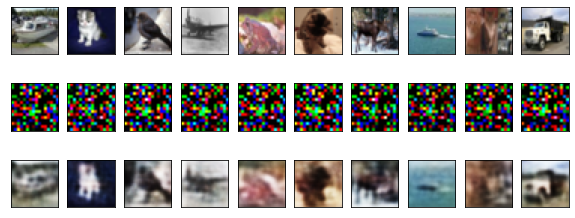

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = numero_imagens, figsize = (10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)